In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import datetime
import matplotlib
import seaborn as sns

import matplotlib.pyplot as plt
import pandas as pd

SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Considering gauges with catchment area > ~1000km2
The below cell takes a while to run

In [33]:
data_dir_gaugeList = '/g/data/w97/ad9701/drought_2017to2020/HRS_data/'
data_dir = '/g/data/w97/ad9701/drought_2017to2020/HRS_data_till2022/'
fig_dir = 'figures/drought_2017to2020/streamflow/'

stn_file = 'hrs_stations_gt905km2.csv'
df_stn = pd.read_csv(data_dir_gaugeList + stn_file)
# df_stn.head()
df_stn = df_stn.sort_values(by = "Catchment Area (km2)", ascending = False)

stn_Nos = df_stn['AWRC Statiion Number'].values

# All the basins in the file
# basin_list = np.unique(df_stn['Basin'].values)
# ordered basins - dry inland - north coastal - south coastal
basin_list = ['Paroo', 'Condamine-Culgoa', 'Border', 'Clarence', 'Gwydir', 'Namoi', 'Castlereagh', 'Manning', 'Hunter', 'Macquarie-Bogan', 'Lachlan', 'Shoalhaven', 'Murrumbidgee', 'Upper-Murray']

# baseline = slice('1981-03-01', '2020-05-31')  # adjusted the baseline for seasonal sum
# fig_suffix = 'ref_198103_202005'
# ref_title = 'baseline = 198103-201902'

# baseline = slice('1996-03-01', '2020-05-31')  # adjusted the baseline for seasonal sum
# fig_suffix = 'ref_199603_202005'
# ref_title = 'baseline = 199603-201902'

baseline = slice('1980-03-01', '2016-11-30')  # adjusted the baseline for seasonal sum
fig_suffix = 'ref_198003_201611'
ref_title = 'baseline = 198003-201611'

baseline_mon = slice('1980-01-01', '2016-12-31')

# # the timeslice of interest - Tinderbox drought
time_slice = slice('2015-12-01', '2021-02-28')  # adjusted the timeslice for seasonal sum
time_slice_mon = slice('2016-01-01', '2020-12-31')

# a longer timeslice - to check what the typical deficit values look like
# time_slice = slice('1980-03-01', '2021-02-28')  # adjusted the timeslice for seasonal sum
# time_slice_mon = slice('1980-01-01', '2020-12-31')

vname = 'Flow'

# read in the streamflow data using the read_csv function by specifying a header
data_allBasins = []
data_allBasins_flowAbs = []

percAnom_mon_allBasins = []  # list to store monthly anomalies in %
anom_mon_allBasins = []
clim_mon_allBasins = []

percAnom_seas_allBasins = []  # list to store seasonal anomalies
anom_seas_allBasins = []
clim_seas_allBasins = []
list_da_clim_seas_allBasins = []

percAnom_ann_allBasins = []
anom_ann_allBasins = []

for basin_sel in basin_list:
    stn_Nos_basin = df_stn['AWRC Statiion Number'].values[(df_stn['Basin'] == basin_sel) & (df_stn['Catchment Area (km2)']>905)]

    # list containing data for all stations
    list_ds = []

    # some check arrays
    list_count_nan = []
    list_start_date = []

    for iStn in range(len(stn_Nos_basin)):
        test_file = data_dir + str(stn_Nos_basin[iStn]) + '_daily_ts.csv'
        df_test = pd.read_csv(test_file, header = 26)

        # get dates in format datetime64
        date_array = pd.date_range(df_test['Date'][0], periods=len(df_test), freq="D")
        df_test['Date'] = date_array
        list_start_date.append(df_test['Date'][0])

        df_test = df_test.set_index(['Date'])
        # print(df_test['Date'].values[-1])  # to check that the timeseries all end consistently on 28 Feb 2022

        list_count_nan.append(sum(np.isnan(df_test['Flow (ML)'].values)))
        da_test = df_test.to_xarray().rename({'Flow (ML)': 'Flow'})
        
        # The record at some gauges starts mid-year at a year later than 1981, so the data needs to be sliced to avoid incorrect monthly totals
        if da_test['Date.year'][0].values > 1981:
            start_year = da_test['Date.year'][0].values
            da_test = da_test.sel(Date = slice(str(start_year+1)+'-01-01',None))
        list_ds.append(da_test)

    # create an xarray data array containing the data at all the stations
    ds_flow = xr.concat(list_ds, dim = 'station').assign_coords({'station': stn_Nos_basin}).rename({'Date': 'time'})
    ds_flow['Flow'] = ds_flow['Flow'].assign_attrs({'units': 'ML'})
    ds_flow = ds_flow.assign_attrs({'Source': 'http://www.bom.gov.au/water/hrs/'})
    
    print('Basin = ' + basin_sel)
    print(list_count_nan)
    print(list_start_date)
    print('------------------------------------------------')
    
    da_flow_seas = ds_flow[vname].resample(time = "QS-DEC").sum()
    # the monthly climatology from long-term data
    # the monthly anomalies during the drought period
    da_flow_lt_seasClim = da_flow_seas.sel(time = baseline).groupby('time.season').mean('time')
    da_flow_seasSel = da_flow_seas.sel(time = time_slice)
    seasArray = da_flow_seasSel['time.season'].values
    da_seasClim_for_diff = da_flow_lt_seasClim.sel(season = seasArray).rename({'season':'time'}).assign_coords({'time':da_flow_seasSel.time.values})
    da_for_plot = ((da_flow_seasSel - da_seasClim_for_diff)/da_seasClim_for_diff*100).assign_attrs({'units': '%'})
    da_for_plot_avg = da_for_plot.mean('station')
    da_flow_for_plot = da_flow_seasSel.mean('station')
        
    data_allBasins.append(da_for_plot_avg)
    data_allBasins_flowAbs.append(da_flow_for_plot)
    
    da_flow_seasAnom_avg = (da_flow_seasSel - da_seasClim_for_diff).mean('station')
    da_flow_lt_seasClim_avg = da_flow_lt_seasClim.mean('station')
    
    percAnom_seas_allBasins.append(da_for_plot_avg.values)
    anom_seas_allBasins.append(da_flow_seasAnom_avg.values)
    clim_seas_allBasins.append(da_flow_lt_seasClim_avg.sel(season = da_for_plot_avg['time.season'].values).values)
    list_da_clim_seas_allBasins.append(da_flow_lt_seasClim_avg/3)  # flow in ML/month
    
#     # annual data
#     da_flow_ann = ds_flow[vname].resample(time = "AS").sum()
#     da_flow_lt_annClim = da_flow_ann.sel(time = baseline_mon).mean('time')
#     da_flow_annSel = da_flow_ann.sel(time = time_slice_mon) 
#     da_annAnom_perc = ((da_flow_annSel - da_flow_lt_annClim)/da_flow_lt_annClim*100).assign_attrs({'units': '%'})
#     da_annAnom_perc_avg = da_annAnom_perc.mean('station')
#     da_annAnom_avg = (da_flow_annSel - da_flow_lt_annClim).mean('station')
    
#     percAnom_ann_allBasins.append(da_annAnom_perc_avg)
#     anom_ann_allBasins.append(da_annAnom_avg)
    
#     # calculate monthly
#     da_flow_lt = ds_flow[vname].sel(time = baseline_mon).resample(time = 'MS').sum()
#     da_flow_lt_monClim = da_flow_lt.groupby('time.month').mean('time')
#     da_flow_mon_sel = ds_flow[vname].sel(time = time_slice_mon).resample(time = 'MS').sum()
#     da_monClim_forDiff = da_flow_lt_monClim.sel(month = da_flow_mon_sel['time.month'].values).rename({'month':'time'}).assign_coords({'time': da_flow_mon_sel.time.values})
#     da_flow_monAnom = da_flow_mon_sel - da_monClim_forDiff
#     da_flow_monAnom_perc = (da_flow_monAnom/da_monClim_forDiff*100).assign_attrs({'units': '%'})
    
#     # averages over stations in each basin
#     da_flow_monAnom_avg = da_flow_monAnom.mean('station')
#     da_flow_lt_monClim_avg = da_flow_lt_monClim.mean('station')
#     da_flow_monAnom_perc_avg = da_flow_monAnom_perc.mean('station')
    
#     percAnom_mon_allBasins.append(da_flow_monAnom_perc_avg)
#     anom_mon_allBasins.append(da_flow_monAnom_avg)
#     clim_mon_allBasins.append(da_flow_lt_monClim_avg)
    
    # percentage diff during low flows may not mean anything
    # da_flow_lt_seasClim_wnan = da_flow_lt_seasClim.where(da_flow_lt_seasClim > 10000)
    # da_seasClim_for_diff_wnan = da_flow_lt_seasClim_wnan.sel(season = seasArray).rename({'season':'time'}).assign_coords({'time':da_flow_seasSel.time.values})
    # da_for_plot_wnan = ((da_flow_seasSel - da_seasClim_for_diff_wnan)/da_seasClim_for_diff_wnan*100).assign_attrs({'units': '%'})

Basin = Paroo
[0, 0]
[Timestamp('1975-11-24 00:00:00'), Timestamp('1967-04-19 00:00:00')]
------------------------------------------------
Basin = Condamine-Culgoa
[0]
[Timestamp('1950-01-01 00:00:00')]
------------------------------------------------
Basin = Border
[0, 0]
[Timestamp('1973-06-30 00:00:00'), Timestamp('1969-07-11 00:00:00')]
------------------------------------------------
Basin = Clarence
[0, 0, 0, 0]
[Timestamp('1971-08-14 00:00:00'), Timestamp('1965-07-09 00:00:00'), Timestamp('1976-03-28 00:00:00'), Timestamp('1969-07-09 00:00:00')]
------------------------------------------------
Basin = Gwydir
[0]
[Timestamp('1970-03-20 00:00:00')]
------------------------------------------------
Basin = Namoi
[0]
[Timestamp('1950-01-01 00:00:00')]
------------------------------------------------
Basin = Castlereagh
[0]
[Timestamp('1980-02-28 00:00:00')]
------------------------------------------------
Basin = Manning
[0]
[Timestamp('1965-02-03 00:00:00')]
------------------------

In [34]:
%who

BIGGER_SIZE	 MEDIUM_SIZE	 SMALL_SIZE	 anom_ann_allBasins	 anom_mon_allBasins	 anom_seas_allBasins	 ax	 baseline	 baseline_mon	 
basin_list	 basin_sel	 clim_mon_allBasins	 clim_seas_allBasins	 col	 col_sel	 da_annAnom_avg	 da_annAnom_perc	 da_annAnom_perc_avg	 
da_flow_ann	 da_flow_annSel	 da_flow_for_plot	 da_flow_lt	 da_flow_lt_annClim	 da_flow_lt_monClim	 da_flow_lt_monClim_avg	 da_flow_lt_seasClim	 da_flow_lt_seasClim_avg	 
da_flow_monAnom	 da_flow_monAnom_avg	 da_flow_monAnom_perc	 da_flow_monAnom_perc_avg	 da_flow_mon_sel	 da_flow_seas	 da_flow_seasAnom_avg	 da_flow_seasSel	 da_for_plot	 
da_for_plot_avg	 da_monClim_forDiff	 da_seasClim_for_diff	 da_test	 data	 data_allBasins	 data_allBasins_flowAbs	 data_dir	 data_dir_gaugeList	 
date_array	 datetime	 df_stn	 df_test	 ds_flow	 fig	 fig_dir	 fig_suffix	 gpd	 
i	 iStn	 label	 list_count_nan	 list_da_clim_seas_allBasins	 list_ds	 list_start_date	 matplotlib	 np	 
pd	 percAnom_ann_allBasins	 percAnom_mon_allBasins	 percAnom_seas_allB

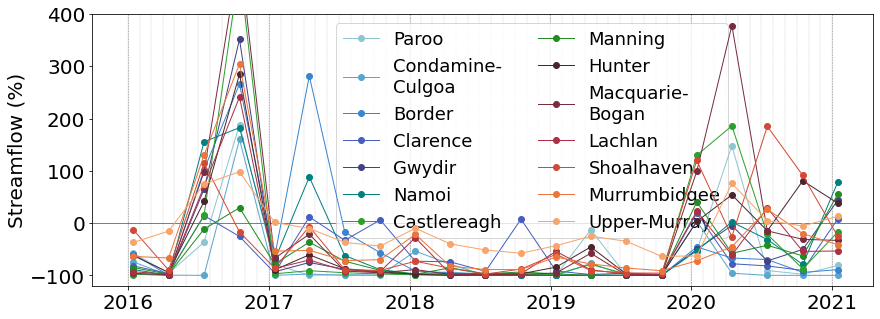

In [35]:
##################################
# SEASONAL ANOMALY PLOT
##################################

fig_dir = 'figures/drought_2017to2020/timeseries_plots/'

basin_list = ['Paroo', 'Condamine-\nCulgoa', 'Border', 'Clarence', 'Gwydir', 'Namoi', 'Castlereagh', 'Manning', 'Hunter', 'Macquarie-\nBogan', 'Lachlan', 'Shoalhaven', 'Murrumbidgee', 'Upper-Murray']

fig, ax = plt.subplots(nrows=1,ncols=1,
                    figsize=(14,5)) #width, height

col_sel = sns.color_palette("icefire", len(basin_list))
col_sel[5] = 'teal'
col_sel[6] = sns.color_palette()[2]
col_sel[7] = 'forestgreen'

seas_breaks = pd.date_range('2015-12-31', freq='M', periods=12*5+1).to_numpy()#.astype(float)
year_breaks = pd.date_range('2015-12-31', freq='Y', periods=6).to_numpy()

for xline in seas_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.2)
for xline in year_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.5)

plt.axhline(0, color = 'black', linestyle = 'solid', linewidth = 0.5)

for data, col, label in zip(data_allBasins, col_sel, basin_list):    
    # arrange the time axis to be in the middle of the seasona
    xval = data.time.values + np.timedelta64(45, 'D')   
    ax.plot(xval, data.values, marker='o', color=col, linewidth=1, zorder=10, label = label)

plt.xlabel('')
ax.set_ylabel('Streamflow (%)')
ax.set_ylim((-120, 400))

plt.legend(bbox_to_anchor=(0.3,1), ncol=2, loc=2)

# fig.savefig(fig_dir + 'AllBasin_mean_streamflow_perc_anom_from_seas_clim_v1.png', bbox_inches='tight', dpi = 300)
# fig.savefig(fig_dir + 'AllBasin_mean_streamflow_perc_anom_from_seas_clim_v1.pdf', bbox_inches='tight', format = 'pdf')

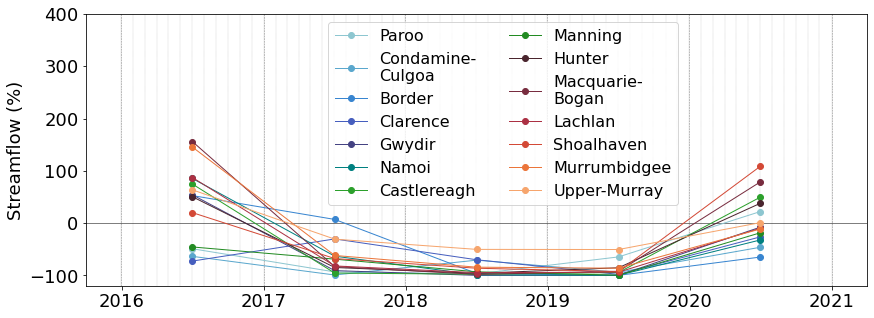

In [26]:
##################################
# ANNUAL ANOMALY PLOT
##################################

fig_dir = 'figures/drought_2017to2020/timeseries_plots/'

basin_list = ['Paroo', 'Condamine-\nCulgoa', 'Border', 'Clarence', 'Gwydir', 'Namoi', 'Castlereagh', 'Manning', 'Hunter', 'Macquarie-\nBogan', 'Lachlan', 'Shoalhaven', 'Murrumbidgee', 'Upper-Murray']

fig, ax = plt.subplots(nrows=1,ncols=1,
                    figsize=(14,5)) #width, height

col_sel = sns.color_palette("icefire", len(basin_list))
col_sel[5] = 'teal'
col_sel[6] = sns.color_palette()[2]
col_sel[7] = 'forestgreen'

seas_breaks = pd.date_range('2015-12-31', freq='M', periods=12*5+1).to_numpy()#.astype(float)
year_breaks = pd.date_range('2015-12-31', freq='Y', periods=6).to_numpy()

for xline in seas_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.2)
for xline in year_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.5)

plt.axhline(0, color = 'black', linestyle = 'solid', linewidth = 0.5)

for data, col, label in zip(percAnom_ann_allBasins, col_sel, basin_list):    
    # arrange the time axis to be in the middle of the seasona
    xval = data.time.values + np.timedelta64(182, 'D')   
    ax.plot(xval, data.values, marker='o', color=col, linewidth=1, zorder=10, label = label)

plt.xlabel('')
ax.set_ylabel('Streamflow (%)')
ax.set_ylim((-120, 400))

plt.legend(bbox_to_anchor=(0.3,1), ncol=2, loc=2)

# fig.savefig(fig_dir + 'AllBasin_mean_streamflow_perc_anom_from_seas_clim_v1.png', bbox_inches='tight', dpi = 600)
# fig.savefig(fig_dir + 'AllBasin_mean_streamflow_perc_anom_from_seas_clim_v1.pdf', bbox_inches='tight', format = 'pdf')

### Plots of the historical record - highly variable streamflow

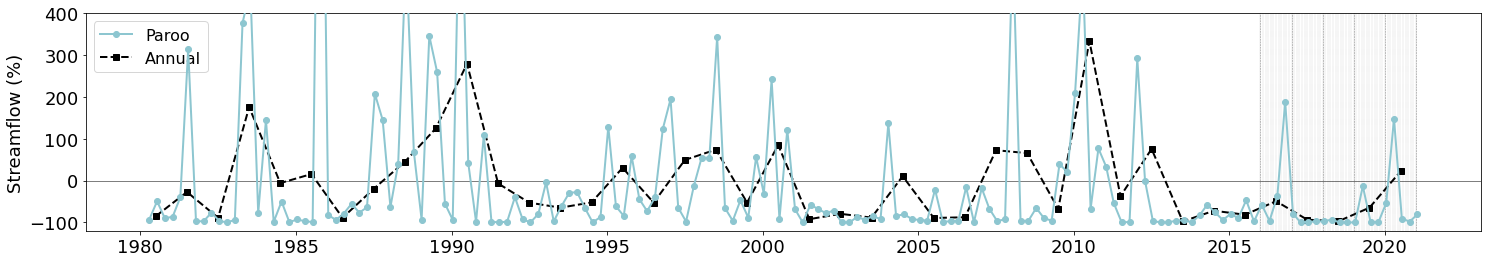

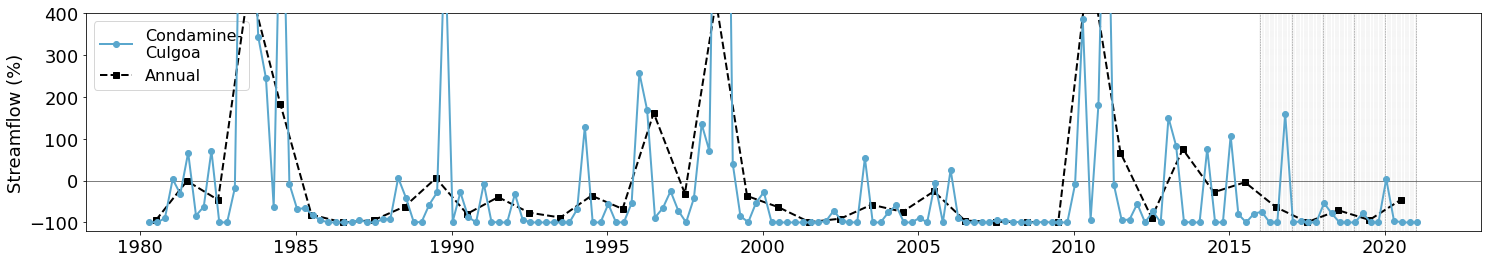

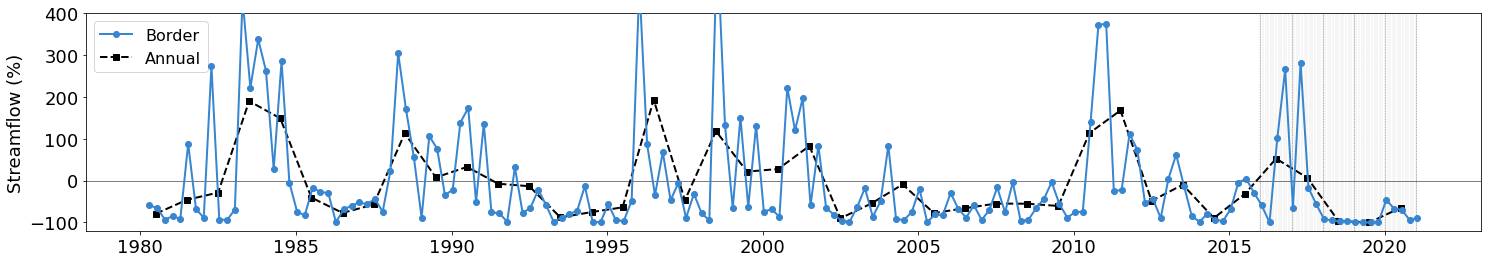

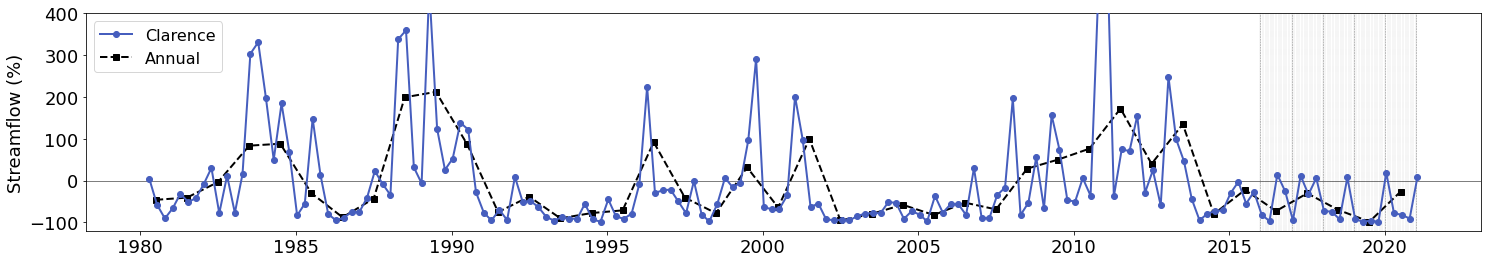

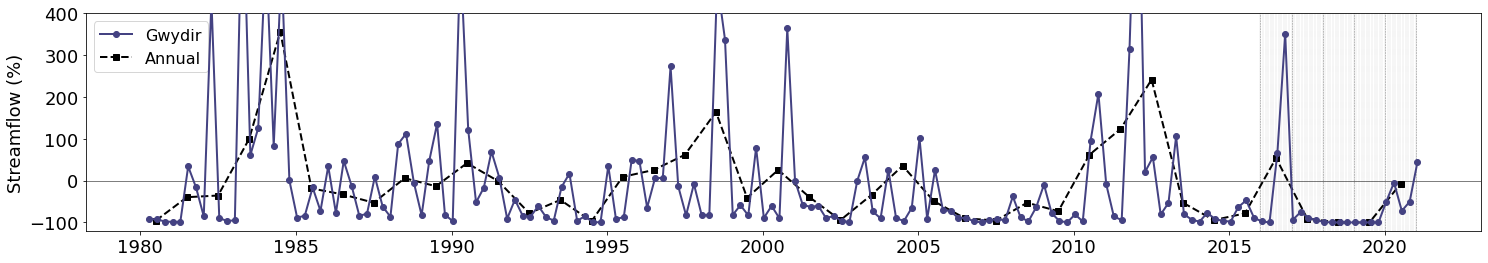

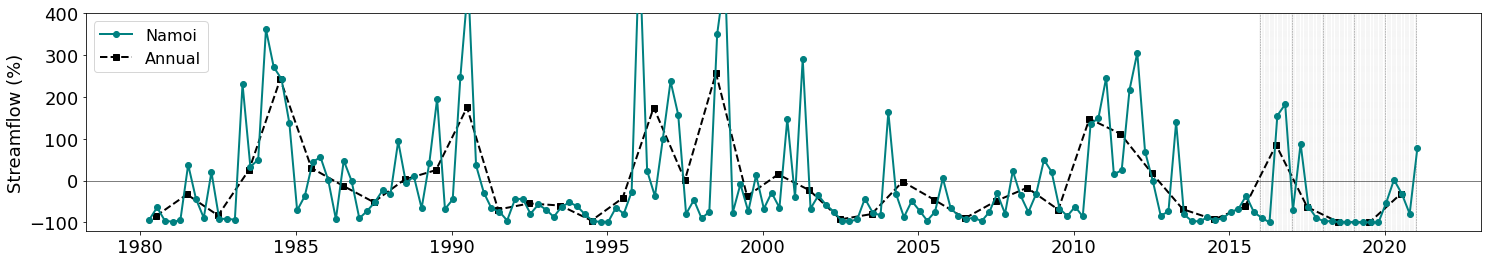

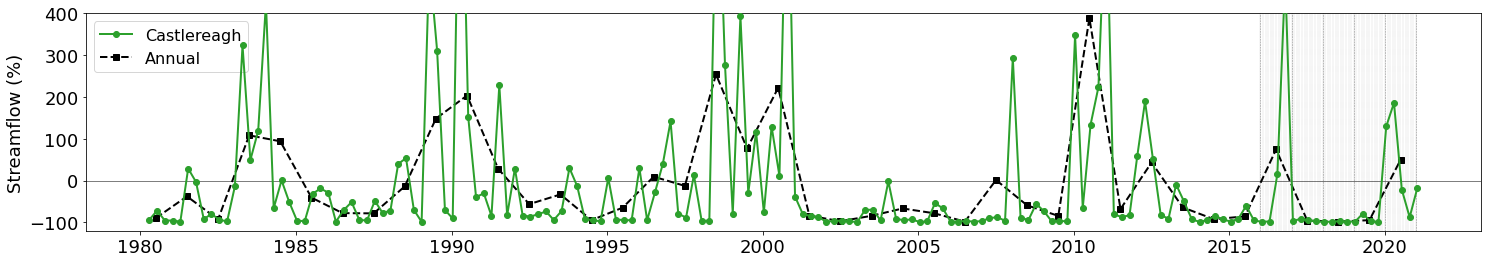

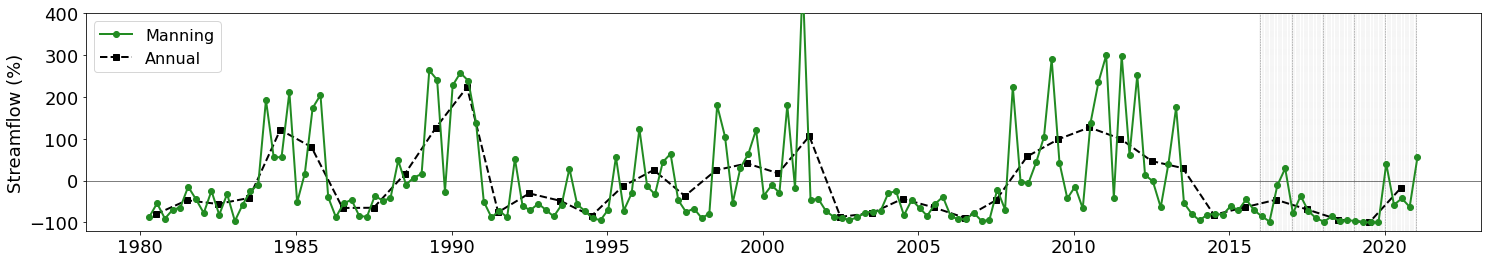

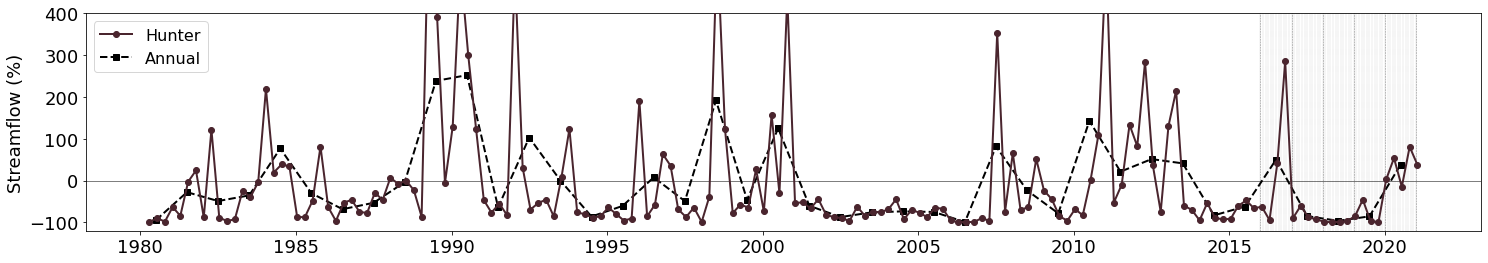

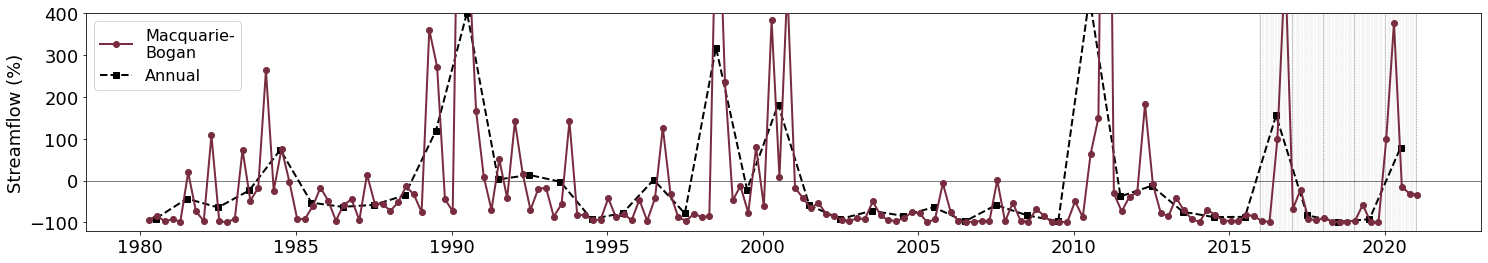

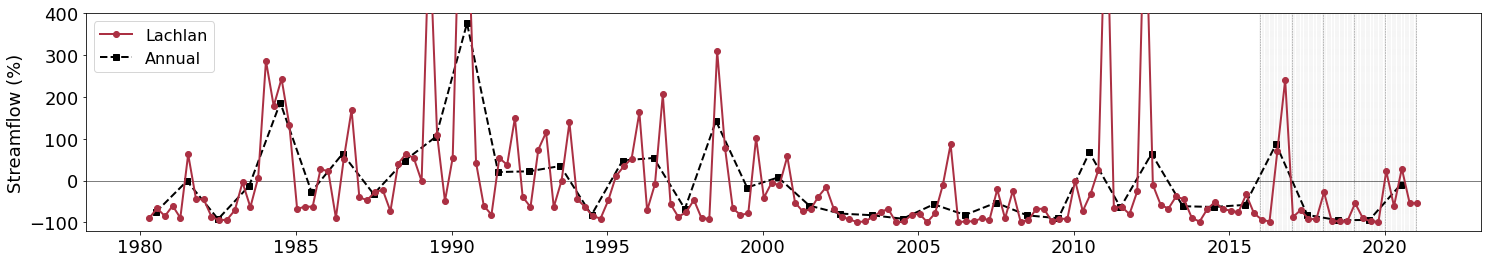

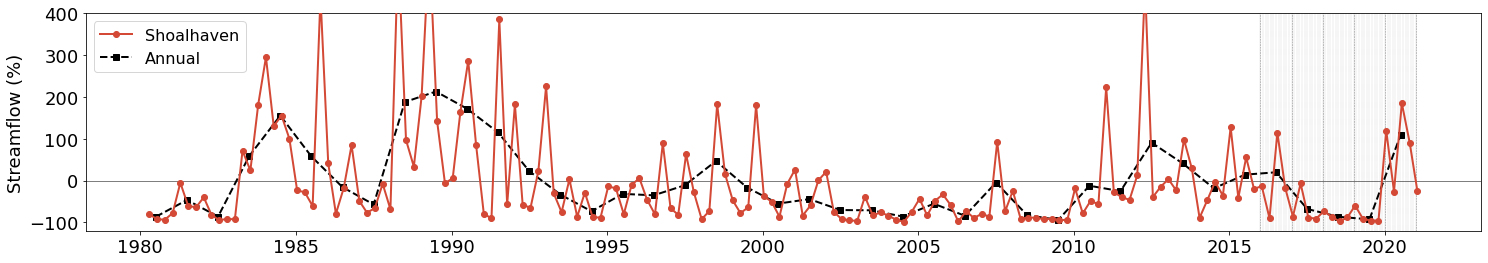

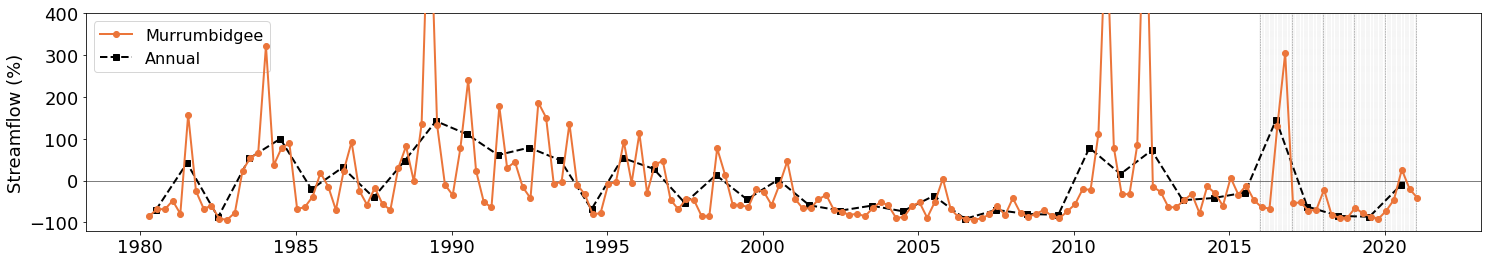

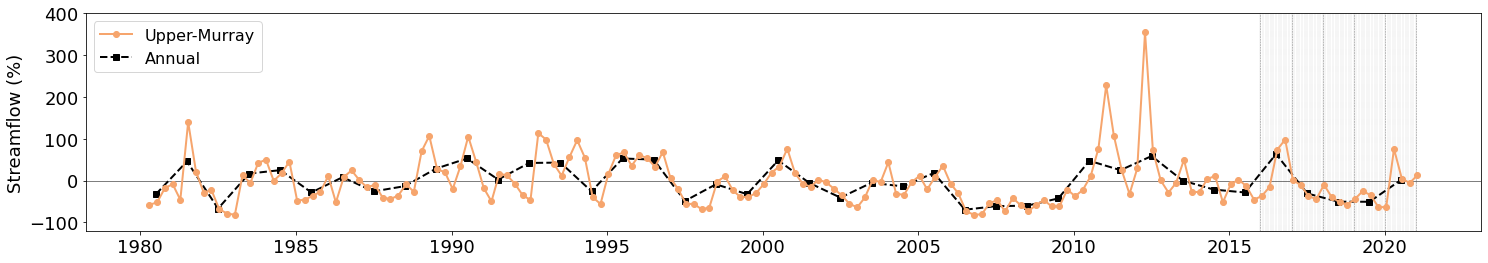

In [12]:
#######
# PLOT
#######
fig_dir = 'figures/drought_2017to2020/timeseries_plots/'

basin_list = ['Paroo', 'Condamine-\nCulgoa', 'Border', 'Clarence', 'Gwydir', 'Namoi', 'Castlereagh', 'Manning', 'Hunter', 'Macquarie-\nBogan', 'Lachlan', 'Shoalhaven', 'Murrumbidgee', 'Upper-Murray']

for iB in range(len(basin_list)):
    fig, ax = plt.subplots(nrows=1,ncols=1,
                        figsize=(25,4)) #width, height

    col_sel = sns.color_palette("icefire", len(basin_list))
    col_sel[5] = 'teal'
    col_sel[6] = sns.color_palette()[2]
    col_sel[7] = 'forestgreen'

    seas_breaks = pd.date_range('2015-12-31', freq='M', periods=12*5+1).to_numpy()#.astype(float)
    year_breaks = pd.date_range('2015-12-31', freq='Y', periods=6).to_numpy()

    for xline in seas_breaks:
        plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.2)
    for xline in year_breaks:
        plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.5)

    plt.axhline(0, color = 'black', linestyle = 'solid', linewidth = 0.5)
    col = col_sel[iB]
    data = data_allBasins[iB] 
    label = basin_list[iB]
    
    # arrange the time axis to be in the middle of the seasona
    xval = data.time.values + np.timedelta64(45, 'D')   
    ax.plot(xval, data.values, marker='o', color=col, linewidth=2, zorder=10, label = label)
    
    data = percAnom_ann_allBasins[iB] 
    # arrange the time axis to be in the middle of the seasona
    xval = data.time.values + np.timedelta64(182, 'D')   
    ax.plot(xval, data.values, marker='s', color='black', linewidth=2, linestyle = '--', zorder=8, label = 'Annual')

    plt.xlabel('')
    ax.set_ylabel('Streamflow (%)')
    ax.set_ylim((-120, 400))
    plt.legend(loc=2)
    #plt.legend(bbox_to_anchor=(0.3,1), ncol=1, loc=2)

    fig.savefig(fig_dir + 'AllBasin_mean_streamflow_perc_anom_from_seas_and_ann_clim_' + basin_list[iB][0:9] + '_1980to2020.png', bbox_inches='tight', dpi = 600)
    fig.savefig(fig_dir + 'AllBasin_mean_streamflow_perc_anom_from_seas_and_ann_clim_' + basin_list[iB][0:9] + '_1980to2020.pdf', bbox_inches='tight', format = 'pdf')

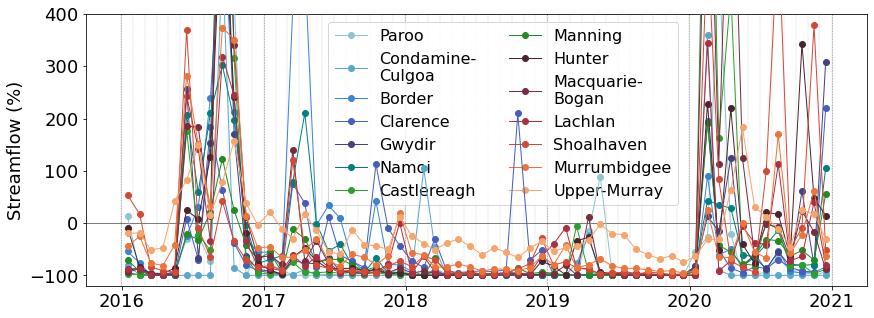

In [17]:
#######
# PLOT
#######

fig_dir = 'figures/drought_2017to2020/timeseries_plots/'

basin_list = ['Paroo', 'Condamine-\nCulgoa', 'Border', 'Clarence', 'Gwydir', 'Namoi', 'Castlereagh', 'Manning', 'Hunter', 'Macquarie-\nBogan', 'Lachlan', 'Shoalhaven', 'Murrumbidgee', 'Upper-Murray']

fig, ax = plt.subplots(nrows=1,ncols=1,
                    figsize=(14,5)) #width, height

col_sel = sns.color_palette("icefire", len(basin_list))
col_sel[5] = 'teal'
col_sel[6] = sns.color_palette()[2]
col_sel[7] = 'forestgreen'

seas_breaks = pd.date_range('2015-12-31', freq='M', periods=12*5+1).to_numpy()#.astype(float)
year_breaks = pd.date_range('2015-12-31', freq='Y', periods=6).to_numpy()

for xline in seas_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.2)
for xline in year_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.5)

plt.axhline(0, color = 'black', linestyle = 'solid', linewidth = 0.5)

for data, col, label in zip(percAnom_mon_allBasins, col_sel, basin_list):    
    # arrange the time axis to be in the middle of the seasona
    xval = data.time.values + np.timedelta64(15, 'D')   
    ax.plot(xval, data.values, marker='o', color=col, linewidth=1, zorder=10, label = label)

plt.xlabel('')
ax.set_ylabel('Streamflow (%)')
ax.set_ylim((-120, 400))

# from matplotlib.lines import Line2D
# legend_elements = []
# for name, col in zip(data_names, col_sel):
#     legend_elements.append(Line2D([0], [0], color=col, lw=1, marker="o",label=name))
# ax.legend(handles=legend_elements, ncol=2, loc=0)
#ax.legend(ncol=2, loc=0)
plt.legend(bbox_to_anchor=(0.3,1), ncol=2, loc=2)

# fig.savefig(fig_dir + 'AllBasin_mean_streamflow_perc_anom_from_mon_clim.png', bbox_inches='tight', dpi = 600)
# fig.savefig(fig_dir + 'AllBasin_mean_streamflow_perc_anom_from_mon_clim.pdf', bbox_inches='tight', format = 'pdf')

### Save percentage anomalies in CSV files for paper text

In [64]:
mon_sel = [4, 5, 6, 7, 8, 9]
AMJJAS_clim = [da.sel(month = da.month.isin(mon_sel)).mean().values for da in clim_mon_allBasins]

mon_sel = [12, 1, 2]
DJF_clim = [da.sel(month = da.month.isin(mon_sel)).mean().values for da in clim_mon_allBasins]

AMJJAS_bars = []
mon_sel = [4, 5, 6, 7, 8, 9]
for da in anom_mon_allBasins:
    da_sel = da.sel(time = da.time.dt.month.isin(mon_sel))
    da_AMJJAS_byyear = da_sel.groupby('time.year').mean()
    AMJJAS_bars.append(da_AMJJAS_byyear.values)

DJF_bars = []
mon_sel = [12, 1, 2]
for da in anom_mon_allBasins:
    da_seas_temp = da.resample(time="QS-DEC").mean()
    da_seas_sel = da_seas_temp.sel(time = da_seas_temp.time.dt.month.isin([12, 1, 2]))
    DJF_bars.append(da_seas_sel.values[1:-1])

###############################
# csv files: AMJJAS anomalies
###############################
    
AMJJAS_time = pd.date_range(start = '2016-06-30', end = '2020-06-30', periods=5).to_numpy()
AMJJAS_time = [x.astype('datetime64[D]') for x in AMJJAS_time]
    
dict_for_df = {'season':['AMJJAS']*5, 'time': AMJJAS_time}

# anomalies in each basin in ML
dict_for_df.update(dict(zip(['anom_MLpermon_' + x for x in basin_list], [np.round(x, 2) for x in AMJJAS_bars])))
    
# anomalies in each basin in %
dict_for_df.update(dict(zip(['anom_perc_' + x for x in basin_list], [np.round(x/y*100,1) for x,y in zip(AMJJAS_bars, AMJJAS_clim)])))
    
# the climatology in ML
dict_for_df.update(dict(zip(['clim_MLpermon_' + x for x in basin_list], [np.round(x, 2) for x in AMJJAS_clim])))

df_anom = pd.DataFrame(dict_for_df)
out_file = '/g/data/w97/ad9701/drought_2017to2020/anomalies_csv/refPeriod_1980to2016/AMJJAS_streamflow_anomalies.csv'
df_anom.to_csv(out_file)

##############################
# csv files: DJF anomalies
##############################

DJF_time = pd.date_range(start = '2017-01-15', end = '2020-01-15', periods=4).to_numpy()
DJF_time = [x.astype('datetime64[D]') for x in DJF_time]

dict_for_df = {'season':['DJF']*4, 'time': DJF_time}

# anomalies in each basin in ML
dict_for_df.update(dict(zip(['anom_ML_' + x for x in basin_list], [np.round(x, 2) for x in DJF_bars])))
    
# anomalies in each basin in %
dict_for_df.update(dict(zip(['anom_perc_' + x for x in basin_list], [np.round(x/y*100,1) for x,y in zip(DJF_bars, DJF_clim)])))
    
# the climatology in ML
dict_for_df.update(dict(zip(['clim_ML_' + x for x in basin_list], [[np.round(x, 2)]*4 for x in DJF_clim])))

df_anom = pd.DataFrame(dict_for_df)
out_file = '/g/data/w97/ad9701/drought_2017to2020/anomalies_csv/refPeriod_1980to2016/DJF_streamflow_anomalies.csv'
df_anom.to_csv(out_file)

################################
# csv files: seasonal anomalies
################################

dict_for_df = {'season':da_for_plot['time.season'].values, 'time': da_for_plot.time.values}

# anomalies in each basin in ML
dict_for_df.update(dict(zip(['anom_ML_' + x for x in basin_list], [np.round(x, 2) for x in anom_seas_allBasins])))
    
# anomalies in each basin in %
dict_for_df.update(dict(zip(['anom_perc_' + x for x in basin_list], [np.round(x,1) for x in percAnom_seas_allBasins])))
    
# the climatology in ML
dict_for_df.update(dict(zip(['clim_ML_' + x for x in basin_list], [np.round(x, 2) for x in clim_seas_allBasins])))

df_anom = pd.DataFrame(dict_for_df)
out_file = '/g/data/w97/ad9701/drought_2017to2020/anomalies_csv/refPeriod_1980to2016/seas_streamflow_anomalies.csv'
df_anom.to_csv(out_file)

In [8]:
# seasonal anomalies over the full record 1980 to 2020

################################
# csv files: seasonal anomalies
################################

dict_for_df = {'season':da_for_plot['time.season'].values, 'time': da_for_plot.time.values}

# anomalies in each basin in ML
dict_for_df.update(dict(zip(['anom_ML_' + x for x in basin_list], [np.round(x, 2) for x in anom_seas_allBasins])))
    
# anomalies in each basin in %
dict_for_df.update(dict(zip(['anom_perc_' + x for x in basin_list], [np.round(x,1) for x in percAnom_seas_allBasins])))
    
# the climatology in ML
dict_for_df.update(dict(zip(['clim_ML_' + x for x in basin_list], [np.round(x, 2) for x in clim_seas_allBasins])))

df_anom = pd.DataFrame(dict_for_df)
out_file = '/g/data/w97/ad9701/drought_2017to2020/anomalies_csv/refPeriod_1980to2016/seas_streamflow_anomalies_1980to2020.csv'
df_anom.to_csv(out_file)

In [13]:
# annual anomalies over the full record 1980 to 2020

################################
# csv files: seasonal anomalies
################################

dict_for_df = {'year':percAnom_ann_allBasins[0]['time.year'].values}
    
# anomalies in each basin in %
dict_for_df.update(dict(zip(['anom_perc_' + x for x in basin_list], [np.round(x,1) for x in percAnom_ann_allBasins])))
    
df_anom = pd.DataFrame(dict_for_df)
out_file = '/g/data/w97/ad9701/drought_2017to2020/anomalies_csv/refPeriod_1980to2016/annual_streamflow_anomalies_1980to2020.csv'
df_anom.to_csv(out_file)

### Read data & create monthly anomaly plots by basin using all gauges in the basin

### Monthly & seasonal climatology plot

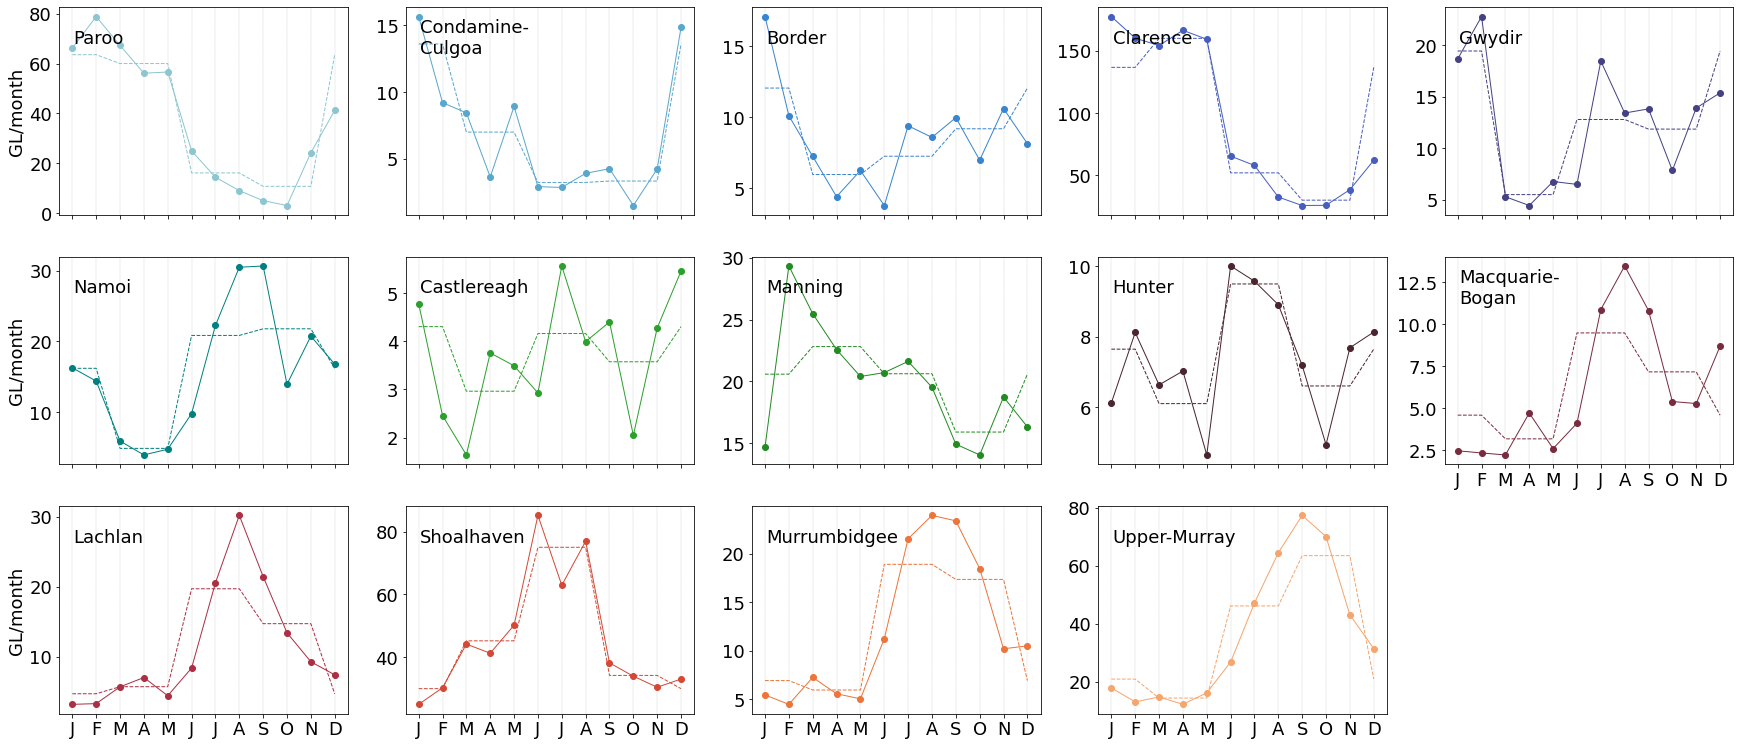

In [53]:
fig_dir = 'figures/drought_2017to2020/timeseries_plots/'
basin_list = ['Paroo', 'Condamine-\nCulgoa', 'Border', 'Clarence', 'Gwydir', 'Namoi', 'Castlereagh', 'Manning', 'Hunter', 'Macquarie-\nBogan', 'Lachlan', 'Shoalhaven', 'Murrumbidgee', 'Upper-Murray']

###################################
# MONTHLY & SEASONAL CLIMATOLOGY 
###################################

col_sel = sns.color_palette("icefire", len(basin_list))
col_sel[5] = 'teal'
col_sel[6] = sns.color_palette()[2]
col_sel[7] = 'forestgreen'

fig, ax = plt.subplots(nrows=3,ncols=5, figsize=(30,13)) #width, height
ax = ax.flatten()

mon_names = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']

def create_monArr_fromSeas(seas_data):
    return(np.array([seas_data[0],seas_data[0], 
     seas_data[2],seas_data[2],seas_data[2],
     seas_data[1],seas_data[1],seas_data[1],
     seas_data[3],seas_data[3],seas_data[3],
     seas_data[0]]))

for iB, da_mon, da_seas, color, label in zip(list(range(len(clim_mon_allBasins))), clim_mon_allBasins, list_da_clim_seas_allBasins, col_sel, basin_list):
    da_seas_in_monArr = create_monArr_fromSeas(da_seas.values)    
    for xline in range(1, 13):
        ax[iB].axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.2)
    ax[iB].plot(da_mon.month.values, da_mon.values/1000, color=color, marker="o", linewidth=1)
    ax[iB].plot(da_mon.month.values, da_seas_in_monArr/1000, color=color, marker=None, linewidth=1, linestyle='--')
    
    ax[iB].set_xlabel('')
    if (iB == 0) | (iB == 5) | (iB == 10):
        ax[iB].set_ylabel('GL/month')
    #ax[iB].set_title(label)
    ax[iB].text(0.05, 0.85, label, ha='left', va='center', transform=ax[iB].transAxes, fontsize=18)
    ax[iB].set_xticks(range(1,13))
    if iB > 8:
        tick_labels=mon_names
    else:
        tick_labels=[]
    ax[iB].set_xticklabels(tick_labels)
    
ax[-1].remove()
                                            
fig.savefig(fig_dir + 'Q_monClim_seasClim_allBasin_' + fig_suffix + '.png', bbox_inches='tight', dpi = 600)
fig.savefig(fig_dir + 'Q_monClim_seasClim_allBasin_' + fig_suffix + '.pdf', bbox_inches='tight', format = 'pdf')